In [1]:
import os

os.chdir("../../../")  # Ensure Current working directory is top level folder where venv is.

import os.path
import math

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import skewnorm
from lmfit.models import GaussianModel, SkewedGaussianModel
from lmfit import Parameters
from source.services.fits_data_unpack_service import FitsDataUnpackService
from source.services.fits_file_load_service import FitsFileLoadService
from source.util import lekid_analysis_tools
from source.util import data_array_analysis_tools
from source.util import scatter_tools

In [18]:
data_directory = r"C:\Users\c2047423\OneDrive - Cardiff University\Documents\Gethin - PhD\Device Data\SPT-SLIM\slim_v2_anlw00X"

device_data_filename = "TonesList_SLIM_17_1.txt"
device_file_path = os.path.join(data_directory, device_data_filename,)

expected_f0_filename = r"C:\Python_Projects\Gdspy Projects\SPT_SLIM\slim_v1\trio_f0_array.txt"

In [28]:
f0_array = np.loadtxt(device_file_path, dtype=float, delimiter="	", usecols=(1), skiprows=1)[1:]
target_f0_array = np.sort(
        np.loadtxt(expected_f0_filename, delimiter=",").flatten()
    )

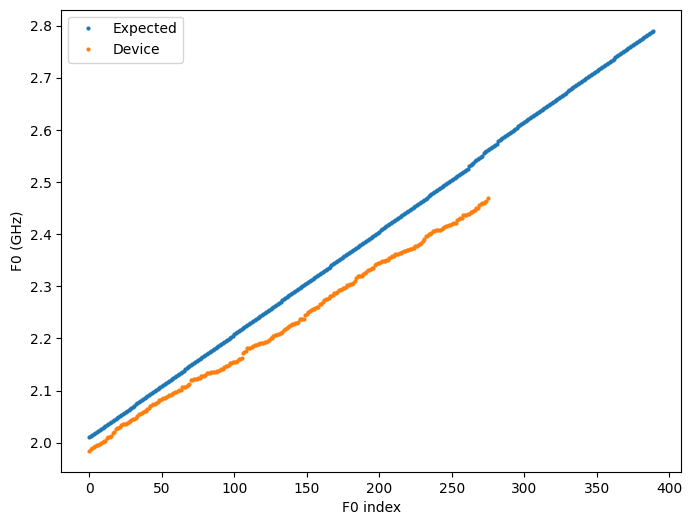

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(target_f0_array*1e-9, linestyle="none", marker="o", markersize=2, label="Expected")
plt.plot(f0_array*1e-9, linestyle="none", marker="o", markersize=2, label="Device")
plt.xlabel("F0 index")
plt.ylabel("F0 (GHz)")
plt.legend()
plt.show()

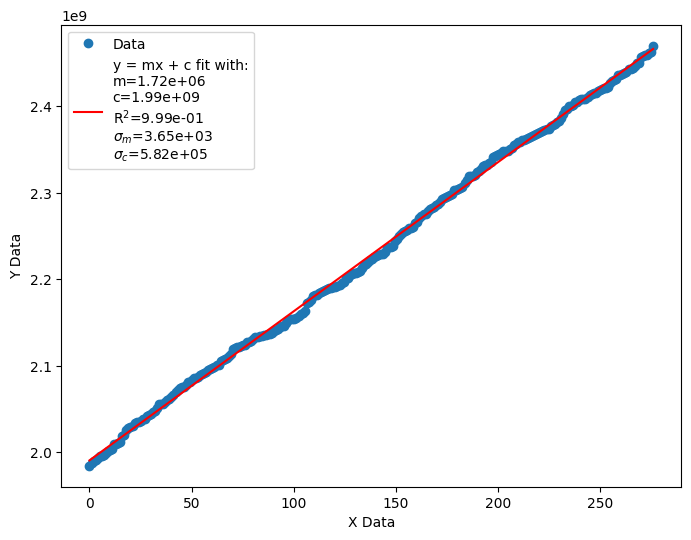

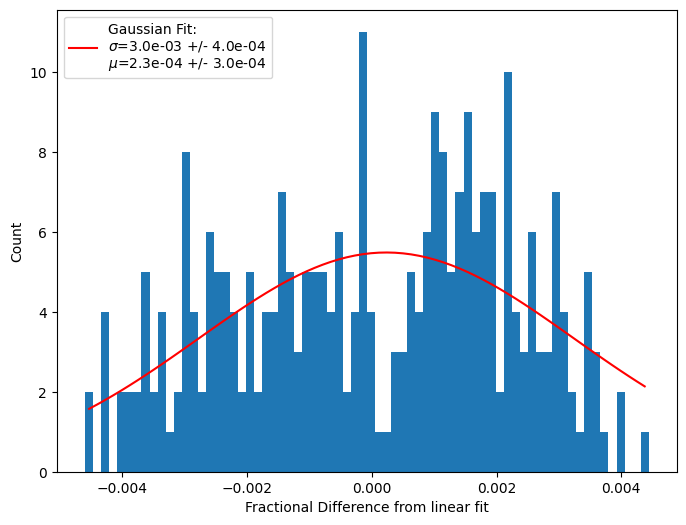

In [30]:
import source.util.general_analysis_tools as general_analysis_tools

n_bins = 70
index_values = np.linspace(0, f0_array.size, f0_array.size)
linear_fit = general_analysis_tools.fit_linear_regression(
    index_values,
    f0_array,
    plot_graph=True,
    plot_title=""
)

best_fit = linear_fit.slope * index_values + linear_fit.intercept
fractional_difference = (f0_array - best_fit) / best_fit

difference_density, difference_bins = np.histogram(fractional_difference, density=False, bins=n_bins)
bin_centres = difference_bins[:-1] + (difference_bins[1] - difference_bins[0]) / 2

# Fit gaussian:
model = GaussianModel()
# parameters = model.guess(difference_density, x=bin_centres)
parameters = Parameters()
parameters.add("sigma", value=4.0, vary=True)
parameters.add("center", value=0, vary=True)
parameters.add("amplitude", value=1.0, vary=True)


b_result = model.fit(difference_density, parameters, x=bin_centres)
result_dict = {}
for name, parameter in b_result.params.items():
    result_dict[name] = [parameter.value, parameter.stderr]
ffs_sigma=float(result_dict["sigma"][0])
ffs_centre=float(result_dict["center"][0])
ffs_sigma_error=float(result_dict["sigma"][1])
ffs_centre_error=float(result_dict["center"][1])


plt.figure(figsize=(8, 6))
plt.hist(fractional_difference, density=False, bins=n_bins)
plt.plot(bin_centres, b_result.best_fit, color="r", label=f"Gaussian Fit:\n$\sigma$={ffs_sigma:.1e} +/- {ffs_sigma_error:.1e}\n$\mu$={ffs_centre:.1e} +/- {ffs_centre_error:.1e}")
plt.xlabel("Fractional Difference from linear fit")
plt.ylabel("Count")
plt.legend()
plt.show()